<a href="https://colab.research.google.com/github/calvin-bales/Lectures/blob/main/2600_project_code_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Calvin Bales\
Physics 2600 Final Project\
Calculating the power output of an array of solar cells on a cloudy day

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.geocoders import Nominatim
import pytz
from pytz import timezone
import pandas as pd
from scipy.integrate import odeint

In quote marks below, enter adress where the solar cells are located. For the purposes of this project, we'll assume that they are located at Barus and Holley.

In [2]:
geolocator = Nominatim()
loc = geolocator.geocode("Barus and Holley Providence RI")
print(loc.address)
print((loc.latitude, loc.longitude))

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


Barus & Holley, 184, Hope Street, Fox Point, Providence, Providence County, Rhode Island, 02912, United States
(41.826550850000004, -71.39789914885344)


To begin, we will define the parameters necessary to calculate the solar time. Solar time is like normal time except that it's purely dependent of the angles of the sun relative to the position on Earth. Since we're calculating solar irradiance (amount of sun that hits Earth), it's useful to think about time in terms of the position of the sun as opposed the the socially constructed time we're accustomed to. 

In [3]:
#sets the local time. since we're interested in observing the power over many hours, we don't just want to know the current time
def local_time(start, end): #give start hour and end hour  
  hour_list = np.arange(start, end+1)
  minute_list = np.arange(start*60, (end+1)*60) 
  return hour_list, minute_list

#defines the time difference between EST/EDT and GMT (Greenwich Mean Time)
def tz_diff(date, tz1, tz2): #give the difference between two time zones (for us, GMT and EST or EDT depending on time of year)
    date = pd.to_datetime(date)
    return (tz1.localize(date) - tz2.localize(date).astimezone(tz1)).seconds/3600

#calculates declination angle
def delta(g): #takes doy
  x = (360/365)*(g-81)
  return 23.45*np.sin(np.radians(x)) #degrees

#equation of time (how much slower or faster solar time is due to non-constant rate of rotation of earth)
def EoT(d): #takes doy
  x = (360/365)*(d-81)
  return 9.87*np.sin(np.radians(2*x))-7.53*np.cos(np.radians(x))-1.5*np.sin(np.radians(x)) 

#calculates solar time
def solar_time(i, l, e):
  return i + e + 4*l - 60*(-4)


#calculates solar hour
def omega(j): # solar time 
  j = j/60
  return (j-12)*15 #degrees

#calculates zenith angle
def zenith(a, b, c): #latitude, declination, solar angle (omega)
  z = np.cos(np.radians(a))*np.cos(np.radians(b))*np.cos(np.radians(c))+ np.sin(np.radians(a))*np.sin(np.radians(b))
  return np.degrees(np.arccos(z))

Calculate the position of the sun over the course of the year

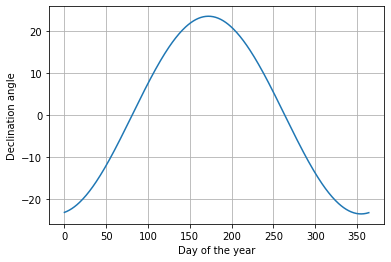

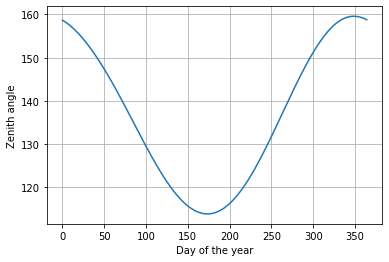

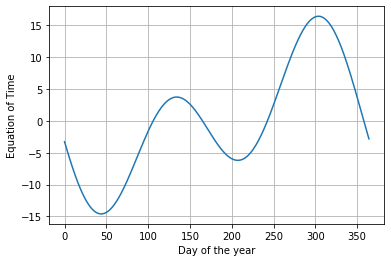

In [4]:
doy = datetime.now().timetuple().tm_yday #defines the day of the year (jan 1 = 1, dec 31 = 365)
phi = loc.latitude #gets latitude of position entered at top

gmt = timezone('GMT')
est = timezone('America/New_York')
t_diff = tz_diff(doy, est, gmt)-1 #-1 because we're on dst
std_mer = t_diff*15
local_mer = loc.longitude

# plot declination angle verses time of year
x = np.arange(0, 365)
y = delta(x)
plt.plot(x,y)
plt.xlabel("Day of the year")
plt.ylabel("Declination angle")
plt.grid()
plt.show()

d = delta(x)
t = x*24*60*60 #convert day to minutes for a year
# solar_t = solar_time(t, EoT(x))
solar_t = solar_time(t, loc.longitude, EoT(x))
w = omega(solar_t)
zen = zenith(phi, d, w)


#plot zenith angle over the course of a year
plt.plot(t/24/60/60, zen)
plt.xlabel("Day of the year")
plt.ylabel("Zenith angle")
plt.grid()
plt.show()

#plot of equaiton of time over year
plt.plot(x, EoT(x))
plt.xlabel("Day of the year")
plt.ylabel("Equation of Time")
plt.grid()
plt.show()

Now that we know the position of the sun over the course of the year, we can look at the average global irradiance over the course of the year.

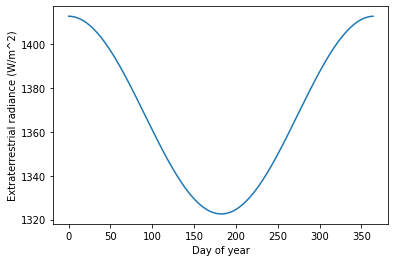

Text(0, 0.5, 'Global Horizontal Irradiance (W/m^2)')

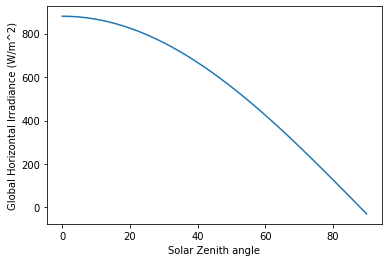

In [5]:
#calculate extraterrestrial radiation
def irr0(n): #takes date
  arg = (2*np.pi/365)*n
  return 1367.7*(1+0.033*np.cos(arg))

def GHI(z): #takes zenith angle
  return 910*np.cos(z)-30

x = np.arange(0, 365)
y = irr0(x)
plt.plot(x,y)
plt.xlabel("Day of year")
plt.ylabel("Extraterrestrial radiance (W/m^2)")
plt.show()
zen = np.linspace(0,np.pi/2, 1000)
plt.plot(np.degrees(zen), GHI(zen))
plt.xlabel("Solar Zenith angle")
plt.ylabel("Global Horizontal Irradiance (W/m^2)")

Calculate sunrise, sunset, and total daylight hours

In [6]:
#hour angle of sunrise/sunset
def ah(d, l): #takes delta (declination angle) and lattitude
  f = np.cos(np.radians(90.833))/(np.cos(np.radians(l))*np.cos(np.radians(d)))
  g = np.tan(np.radians(l))*np.tan(np.radians(d))
  return np.arccos(f-g)

#sunrise
def lds(h, l, s): #hour angle, longitude, equation of time 
  return 720 - 4*(l+h)-s

#sunset 
def cds(h, l, s): #hour angle, longitude, equation of time 
  return 720 - 4*(l-h)-s


ha = np.degrees(ah(delta(doy), loc.latitude))
sr = lds(ha, loc.longitude, EoT(doy))-4*60
ss = cds(ha, loc.longitude, EoT(doy))-4*60
daylight = ss-sr

print("sunrise = ", round(sr/60, 2))
print("sunser = ", round(ss/60, 2))
print("total daylight hours = ", round(daylight/60,2))

sunrise =  5.91
sunser =  19.56
total daylight hours =  13.65


Now we can calculate the position of the sun over the course of a day so that we can calculate the solar irradiance and photovoltaic output over the course of a day.

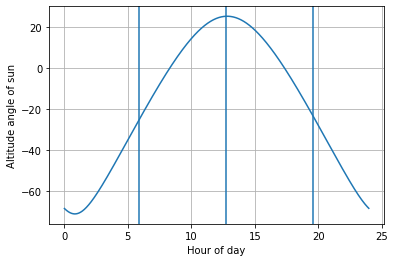

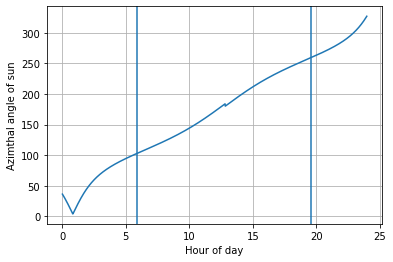

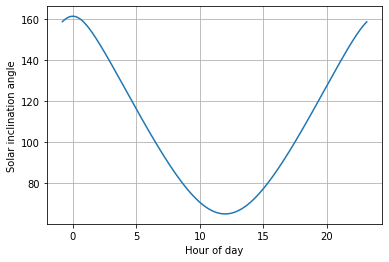

In [21]:
#altitude angle of sun in the sky
def sol_alt(l,d,o): #latitude, delta, omega
  r = np.sin(np.radians(l))*np.sin(np.radians(d))
  u = np.cos(np.radians(l))*np.cos(np.radians(d))*np.cos(np.radians(o))
  return np.degrees(np.arcsin(r+u))

def sol_azimuth(l, z, d):
  num = np.sin(np.radians(l))*np.cos(np.radians(z))-np.sin(np.radians(d))
  den = np.cos(np.radians(l))*np.sin(np.radians(z))
  return np.degrees(np.arccos(num/den))

#sun's incident angle of the solar panels
def sol_inc(b, z, asol, am): #takes tilt of panels (0=flat), zenith angle of sun, azimuthal angle of sun, azimuthal angle of panels (N=0deg, E=90deg)
  k = np.cos(np.radians(b))*np.cos(np.radians(z))+np.sin(np.radians(b))*np.sin(np.radians(z))*np.cos(np.radians(asol-am))
  return np.degrees(np.arccos(k))

delt = delta(doy)
phi = loc.latitude
temps = np.arange(0, 1440)
solar_tday = solar_time(temps, loc.longitude, EoT(doy))
wday = omega(solar_tday)
zenday = zenith(phi, delt, wday)

alt = sol_alt(phi, delt, wday)

azi = sol_azimuth(loc.latitude, zenday, delt)
for i in range(len(wday)):
  if wday[i]>0:
    azi[i] = (azi[i]+180)%360
  else:
    azi[i] = (544-azi[i])%360

inc = sol_inc(0, zenday, azi, 180)
# time_noaa = np.arange(240)

plt.plot(temps/60, alt)
plt.xlabel("Hour of day")
plt.ylabel("Altitude angle of sun")
plt.axvline(x=sr/60)
plt.axvline(x=ss/60)
plt.axvline(x=(((ss-sr)/2)+sr)/60)
plt.grid()
plt.show()
plt.plot(temps/60, azi, label="Calculated data")
# plt.plot(time_noaa/10, azi_day_noaa, "--", label="NOAA data")
plt.axvline(x=sr/60)
plt.axvline(x=ss/60)
plt.xlabel("Hour of day")
plt.ylabel("Azimthal angle of sun")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()
plt.plot(solar_tday/60, inc)
plt.xlabel("Hour of day")
plt.ylabel("Solar inclination angle")
plt.grid()
plt.show()

Loads files in order to compare NOAA's calculated data with my own.

In [ ]:
#load files
import google.colab
# from google.colab import files  # Using the files method in example below

# Ask for file selection on your laptop
print("You should choose a file from your machine to upload to the Colab virtual machine\n")
uploaded = google.colab.files.upload()

print("\n")
for fn in uploaded.keys():
  print(
    'User uploaded file "{name}" with length {length} bytes is now in /content/ directory'.format(
      name=fn, length=len(uploaded[fn]))
  )

# A simple *unix command tto the shell ! that lists the directory contents
!ls "/content/"


You should choose a file from your machine to upload to the Colab virtual machine





sample_data


In [ ]:
data = np.genfromtxt(fn, delimiter=',') 
EoT_noaa = data[:,0]
# azi_day_noaa = data[:,0]
# z_day_noaa = data[:,0]
# solt_noaa = data[:,0]
# zen_noaa = data[:]
# alt_day_noaa = data[:,0]

Calculates the solar irradiance over the course of the day and defines the diffuse irradiance, which is the portion of the total irradiance that is due to the scattering of light as it passes through the atmosphere. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


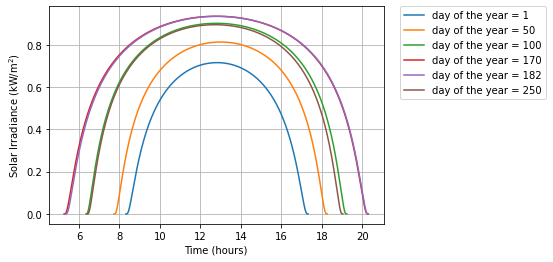

In [26]:
jours = [1, 50, 100, 170, 182, 250]

for doy in jours:
  delt = delta(doy)
  phi = loc.latitude
  temps = np.arange(0, 1440)
  solar_tday = solar_time(temps, loc.longitude, EoT(doy))
  wday = omega(solar_tday)
  zenday = zenith(phi, delt, wday)

  alt = sol_alt(phi, delt, wday)

  azi = sol_azimuth(loc.latitude, zenday, delt)
  for i in range(len(wday)):
    if wday[i]>0:
      azi[i] = (azi[i]+180)%360
    else:
      azi[i] = (544-azi[i])%360

  inc = sol_inc(0, zenday, azi, 180)
  plt.plot(temps/60, sol_irr(inc), label = "day of the year = "+ str(doy))

plt.ylabel("Solar Irradiance (kW/m$^2$)")
plt.xlabel("Time (hours)")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


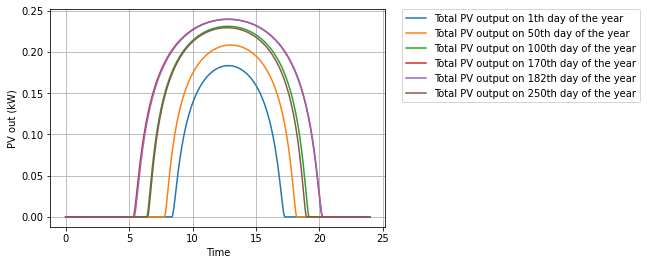

In [31]:
jours = [1, 50, 100, 170, 182, 250]

for doy in jours:
  delt = delta(doy)
  phi = loc.latitude
  temps = np.arange(0, 1440)
  solar_tday = solar_time(temps, loc.longitude, EoT(doy))
  wday = omega(solar_tday)
  zenday = zenith(phi, delt, wday)

  alt = sol_alt(phi, delt, wday)

  azi = sol_azimuth(loc.latitude, zenday, delt)
  for i in range(len(wday)):
    if wday[i]>0:
      azi[i] = (azi[i]+180)%360
    else:
      azi[i] = (544-azi[i])%360

  inc = sol_inc(0, zenday, azi, 180)

  sun = np.nan_to_num(sol_irr(inc)) #changes nan (values before sunrise and after sunset) to zeros 
  tot_irr = np.sum(sun)

  out_power = PVout(17, sun)

  T = 3

  es = vap_P(T, 2.5e6) 
  e = vap_P(T_d, 2.5e6)
  rv = mix_ratio(e, P)
  rls = mix_ratio(es, P)

  rate = RK4(rv, rls, 0, 24, 1440) #set rc=1 -- saturated 

  cloudiness = rate[2]
  timetime = rate[0]
  liste = np.arange(len(cloudiness))

  #rescale cloudiness
  cover = []
  max_cloud = max(cloudiness)
  for i in liste:
    n = cloudiness[i]/max_cloud
    n = 1-n
    cover.append(n)

  # move clouds to form in the middle of the day for more interesting plot
  cloud = []
  p=0
  for i in range(len(temps)):
    if temps[i]<720:
      cloud.append(1)
    else:
      p+=1
      cloud.append(cover[p])

  PV_cover = out_power*cloud
  diff = diffuse(zen[doy])/1000 #convert Watts to kW

  scatter = []
  for i in range(len(PV_cover)):
    n = sun[i]/max(sun)
    b = diff*n
    s = PVout(T, b)
    scatter.append(s)

  shadelight = scatter+PV_cover
  plt.plot(temps/60, out_power, label = "Total PV output on "+str(doy)+"th day of the year")


#   plt.plot(temps/60, shadelight*1000, label = "PV out with clouds on "+str(doy)+"th day of the year")

# plt.grid()
# plt.xlabel("Time")
# plt.ylabel("PV out (W)")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.show()

#plt.plot(temps/60, test, label = "Diffuse PV output")
plt.grid()
plt.xlabel("Time")
plt.ylabel("PV out (kW)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


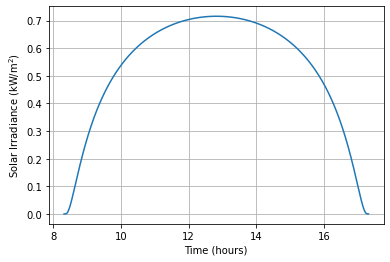

In [20]:
def sol_irr(ang):
  AM = (1/np.cos(np.radians(ang)))**0.678
  return 1.353*0.7**AM

def diffuse(zen): #takes zenith angle in degrees -- light scattered through atmosphere to account for light in shade
  b = (np.pi/2)-np.radians(zen)
  return 14.29+21.04*b

plt.plot(temps/60, sol_irr(inc))
plt.ylabel("Solar Irradiance (kW/m$^2$)")
plt.xlabel("Time (hours)")
plt.grid()

Uses the solar irradiance over the course of a day to calculate the photovoltaic output for an array of solar cells.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


(5.906737692845993, 19.559562568847312)

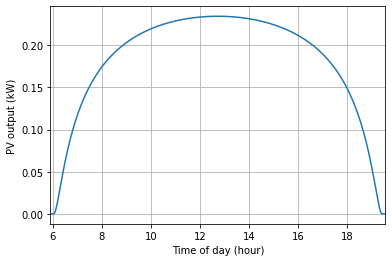

In [9]:
# calculating solar panel output
sun = np.nan_to_num(sol_irr(inc)) #changes nan (values before sunrise and after sunset) to zeros 

def PVout(T, G, C=0.285, D=0.9, a=-0.0028): 
  k = 0.03
  Tc = G*k+T 
  Tsct = k + T
  return C*D*(1+a*(Tc-Tsct))*G

tot_irr = np.sum(sun)
#print(tot_irr)

out_power = PVout(17, sun)

plt.plot(temps/60, out_power)
plt.grid()
plt.xlabel("Time of day (hour)")
plt.ylabel("PV output (kW)")
plt.xlim(sr/60, ss/60)

Begin the process of cloud formation by defining the parameters required for the process. 

In [10]:
#actual vapor pressure takes dew point temperature, saturated vapor pressure takes air temperature
def vap_P(T, L): #e(dew temp, latent heat) or e_s(temperature, latent heat) 
  R_v = 461 #J/kgK
  T = T+273.3 #C to K
  delt_T = (1/273.3)-(1/T)
  exponent = (L/R_v)*delt_T
  return 6.113*np.exp(exponent)

#actual mixing ratio takes actual vapor pressure, saturated mixing ratio takes saturation vapor pressure. Both take pressure (mbar)
def mix_ratio(e, P): #rv
  return 0.622*e/(P-e)

def air_density(T, P, vap): #takes tempreature[C], pressure [millibar] and vapor pressure [millibar]
  R = 8.3145 #J/Kmol (universal gas constant)
  Ma = 0.0289 #kg/mol (molar mass of dry air)
  Mv = 0.018 #kg/mol (molar mass of water vapor)
  P = P*100 #mb to Pa
  vap = vap*100
  Pa = P - vap
  T += 273.3 #C to K
  return (Pa*Ma+vap*Mv)/(R*T)

def amount(d, r): #takes density and mixing ratio [kg/m^3] -- q
  return d*r

In [11]:
#mixing ratio of cloud liquid rate of change
def dcloud_mix(rv, rls):
  return 0.75*(rv-rls)

#mixing ratio of water vapor rate of change 
def dvap_mix(rv, rls, t):
  return -0.75*(rv-rls)

#cloud ice mass nucleated in each time step
def ci_mass(rv, ris):
  mp = 10**(-11) #kg
  return 1000*mp*np.exp(-0.639+12.96*((rv/ris) -1))

#cloud crystal growth rate
def grow_cc(qp, qis, qv, t):
  Cvp = 25
  return Cvp*(qv-qis)*qp

#rain production rate
def make_rain(qr, qc, t):
  Ccr = 17
  return Ccr*qr*qc

#evaporation rate
def evap_rain(rls, rv):
  Crv = 10**-3
  return -Crv*(rls-rv)

#fall velocity
def FV(rr, rho):
  return 13*(rr**0.125)*(rho**-0.5)

Define current conditions for the cloud formation process.

In [12]:
######DEFINE CURRENT CONDITIONS######
#Temperatures need to be in degrees celcius
T = 8
T_d = 4

#Pressure needs be in mbar
P = 1011 

#set time range
time = local_time(0, 23)[0]

Calculate the cloud parameters give the current conditions.

In [13]:
#calculate r_v and r_ls and ris
e = vap_P(T, 2.5e6) 
rv = mix_ratio(e, P)
es = vap_P(T_d, 2.5e6)
rls = mix_ratio(es, P)
esi = vap_P(T_d, 2.38e6)
ris = mix_ratio(esi, P)
rho = air_density(T, P, es)
qis = ris*rho
qv = rv*rho

print(es/e)

0.7572315282313226


The cloud formation process over the course of a day.

0.007161191294696528


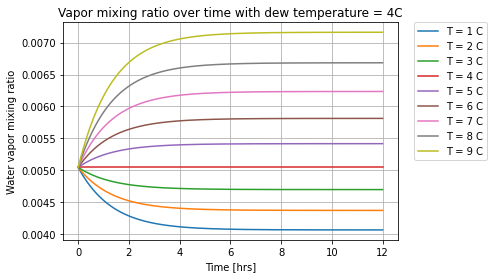

0.007161191294696528


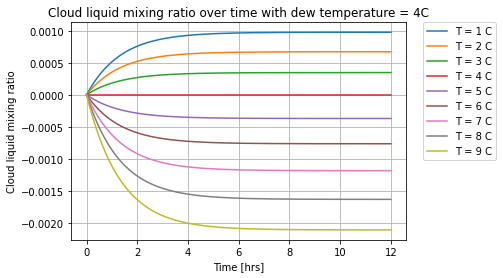

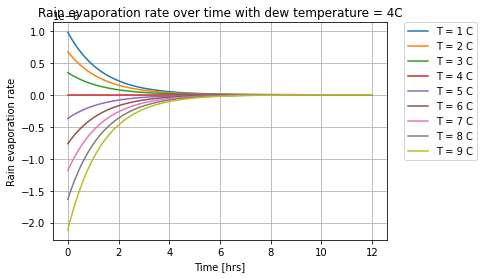

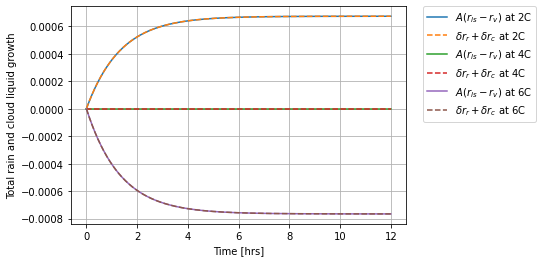

In [14]:
#cloud liquid and water vapor mixing ratio rates of change 

def RK4(rv, rls, start, end, N):
    time = np.linspace(start,end,N)
    h = (end-start)/N
    mixing_water = []
    mixing_cloud = []
    rain = []
    rc = 0
    for t in time:
        if t==0:
            rv=rv
        else:
            k1 = h*dvap_mix(rv, rls, t)
            k2 = h*dvap_mix(rv+k1/2, rls, t+h/2)
            k3 = h*dvap_mix(rv+k2/2, rls, t+h/2)
            k4 = h*dvap_mix(rv+k3, rls, t+h)
            rv += (k1+2*k2+2*k3+k4)/6
            rc -= (k1+2*k2+2*k3+k4)/6
          
        mixing_water.append(rv)
        mixing_cloud.append(rc)
        rain.append(evap_rain(rls, rv))
    mixing_water = np.array(mixing_water)
    mixing_cloud = np.array(mixing_cloud)
    time = np.array(time)
    rain = np.array(rain)
    return time, mixing_water, mixing_cloud, rain 


degrees = [1,2,3,4,5,6,7,8,9] #current temperature [C]
T_dew = 4 #dew point [C]
P = 1011 #mBar 

for t in degrees:
  es = vap_P(t, 2.5e6) 
  e = vap_P(T_d, 2.5e6)
  rv = mix_ratio(e, P)
  rls = mix_ratio(es, P)

  rate = RK4(rv, rls, 0, 12, 1000) #set rc=1 -- saturated 
  plt.plot(rate[0], rate[1], label="T = "+ str(t)+ " C")

print(rate[1][-1])
plt.grid()
plt.xlabel("Time [hrs]")
plt.ylabel("Water vapor mixing ratio")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Vapor mixing ratio over time with dew temperature = 4C")
plt.show()

for t in degrees:
  es = vap_P(t, 2.5e6) 
  e = vap_P(T_d, 2.5e6)
  rv = mix_ratio(e, P)
  rls = mix_ratio(es, P)

  rate = RK4(rv, rls, 0, 12, 1000) #set rc=1 -- saturated 
  plt.plot(rate[0], rate[2], label="T = "+ str(t)+ " C")

print(rate[1][-1])
plt.grid()
plt.xlabel("Time [hrs]")
plt.ylabel("Cloud liquid mixing ratio")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Cloud liquid mixing ratio over time with dew temperature = 4C")
plt.show()

for t in degrees:
  es = vap_P(t, 2.5e6) 
  e = vap_P(T_d, 2.5e6)
  rv = mix_ratio(e, P)
  rls = mix_ratio(es, P)

  rate = RK4(rv, rls, 0, 12, 1000) #set rc=1 -- saturated 
  plt.plot(rate[0], rate[3], label="T = "+ str(t)+ " C")


plt.grid()
plt.xlabel("Time [hrs]")
plt.ylabel("Rain evaporation rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Rain evaporation rate over time with dew temperature = 4C")
plt.show()

# check that dr_r+dr_c is less than or equal to A(r_ls-r_r)
atemp = [2, 4, 6]

for t in atemp:
  es = vap_P(t, 2.5e6) 
  e = vap_P(T_d, 2.5e6)
  rv = mix_ratio(e, P)
  rls = mix_ratio(es, P)

  rate = RK4(rv, rls, 0, 12, 1000) #set rc=1 -- saturated
  tot = rate[3]+rate[2]
  plt.plot(rate[0], rate[2], label = "$A(r_{ls}-r_v)$ at " + str(t)+"C")
  plt.plot(rate[0], tot, label = "$\delta r_r + \delta r_c$ at "+ str(t)+"C", linestyle = "--")

plt.grid()
plt.xlabel("Time [hrs]")
plt.ylabel("Total rain and cloud liquid growth")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Adding the impact of the forming clouds to the photovoltaic output.

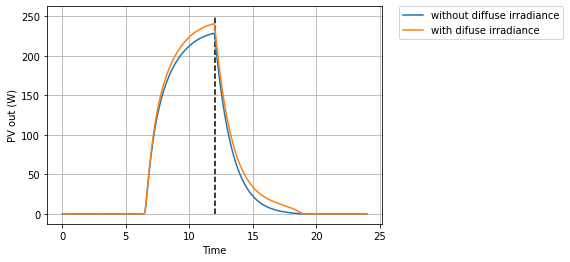

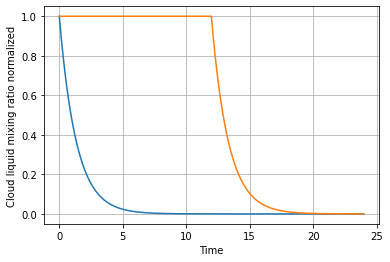

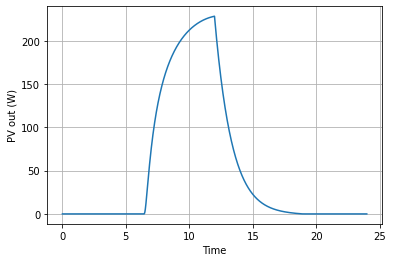

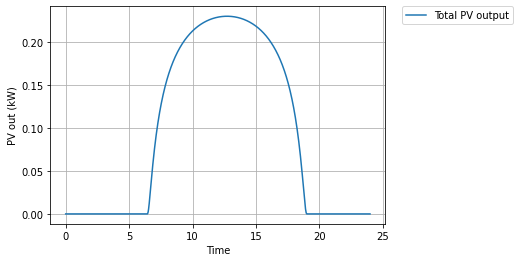

In [37]:
# assigning values to decrease PV output
degs = [1]

for T in degs: 
  es = vap_P(T, 2.5e6) 
  e = vap_P(T_d, 2.5e6)
  rv = mix_ratio(e, P)
  rls = mix_ratio(es, P)

  rate = RK4(rv, rls, 0, 24, 1440) #set rc=1 -- saturated 

  cloudiness = rate[2]
  timetime = rate[0]
  liste = np.arange(len(cloudiness))

  #rescale cloudiness
  cover = []
  max_cloud = max(cloudiness)
  for i in liste:
    n = cloudiness[i]/max_cloud
    n = 1-n
    cover.append(n)

  # move clouds to form in the middle of the day for more interesting plot
  cloud = []
  p=0
  for i in range(len(temps)):
    if temps[i]<720:
      cloud.append(1)
    else:
      p+=1
      cloud.append(cover[p])

  PV_cover = out_power*cloud
  diff = diffuse(zen[doy])/1000 #convert Watts to kW

  scatter = []
  for i in range(len(PV_cover)):
    n = sun[i]/max(sun)
    b = diff*n
    s = PVout(T, b)
    scatter.append(s)

  shadelight = scatter+PV_cover

  plt.plot(temps/60, PV_cover*1000, label = "without diffuse irradiance")
  plt.plot(temps/60, shadelight*1000, label = "with difuse irradiance")
plt.vlines(12, 0, 250, linestyles="--")
plt.grid()
plt.xlabel("Time")
plt.ylabel("PV out (W)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

plt.plot(temps/60, cover)
plt.plot(temps/60, cloud)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Cloud liquid mixing ratio normalized")
plt.show()

#out_power = PVout(17, sun)

plt.plot(temps/60, PV_cover*1000)
plt.grid()
plt.xlabel("Time")
plt.ylabel("PV out (W)")
plt.show()
#plt.plot(out_power)

plt.plot(temps/60, out_power, label = "Total PV output")
#plt.plot(temps/60, test, label = "Diffuse PV output")
plt.grid()
plt.xlabel("Time")
plt.ylabel("PV out (kW)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Exploring the mixing ratio and vapor pressure as a function of temperature.

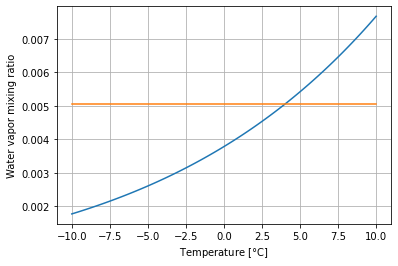

Text(0, 0.5, 'Water vapor pressure')

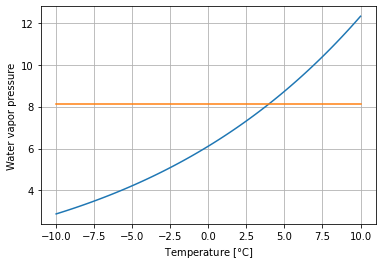

In [ ]:
#mixing ratio and vapor pressure as a function of temperature 
T_d = 4
degrees = np.linspace(-10, 10, 100)

mixing = []
sat_mixing = []
vapor = []
sat_vap = []
for t in degrees:
  es = vap_P(t, 2.5e6) 
  e = vap_P(T_d, 2.5e6)
  rv = mix_ratio(e, P)
  rls = mix_ratio(es, P)
  vapor.append(es)
  mixing.append(rls)
  sat_mixing.append(rv)
  sat_vap.append(e)

plt.plot(degrees, mixing)
plt.plot(degrees, sat_mixing)
plt.grid()
plt.xlabel("Temperature [$\degree$C]")
plt.ylabel("Water vapor mixing ratio")
plt.show()
plt.plot(degrees, vapor)
plt.plot(degrees, sat_vap)
plt.grid()
plt.xlabel("Temperature [$\degree$C]")
plt.ylabel("Water vapor pressure")

Exploring the Gibbs free energy as a function of droplet size.

1.4139347722886448


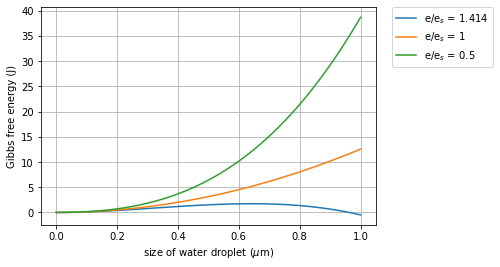

In [ ]:
# Gibbs free energy as a function of droplet size 
T = 9

e = vap_P(T, 2.5e6) 
rv = mix_ratio(e, P)
es = vap_P(T_d, 2.5e6)
rls = mix_ratio(es, P)

def Gibbs(a, n, T, e, ew):
  sigma = 1#72.86 #mN/m surface tension of water
  kb = 1.38e-23
  return 4*np.pi*a**2*sigma-(4/3)*np.pi*a**3*n*T*np.log(e/ew)


a = np.linspace(0, 1, 101)
gibbs_e = Gibbs(a, 1, T, e, es)
gibbs_1 = Gibbs(a, 1, T, 1, 1)
gibbs_01 = Gibbs(a, 1, T, 1, 2)
plt.plot(a, gibbs_e, label = "e/e$_s$ = " + str(round(e/es,3)))
plt.plot(a, gibbs_1, label = "e/e$_s$ = 1")
plt.plot(a, gibbs_01, label = "e/e$_s$ = 0.5")
plt.grid()
plt.xlabel("size of water droplet ($\mu$m)")
plt.ylabel("Gibbs free energy (J)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

print(e/es)

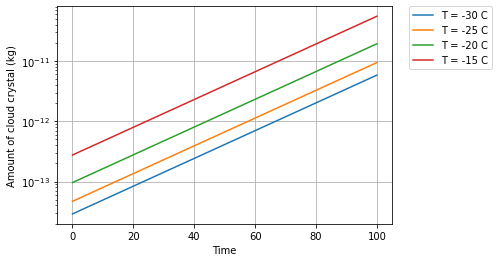

In [ ]:
#diffusional cloud crystal growth rate
e = vap_P(T, 2.5e6) 
rv = mix_ratio(e, P)
es = vap_P(T_d, 2.5e6)
rls = mix_ratio(es, P)

def RK4(qv, qis, qp0, start, end, N):
    time = np.linspace(start,end,N)
    h = (end-start)/N
    cloud = []
    for t in time:
        if t==0:
            qp=qp0
        else:
            k1 = h*grow_cc(qp, qis, qv, t)
            k2 = h*grow_cc(qp+k1/2, qis, qv, t+h/2)
            k3 = h*grow_cc(qp+k2/2, qis, qv, t+h/2)
            k4 = h*grow_cc(qp+k3, qis, qv, t+h)
            qp += (k1+2*k2+2*k3+k4)/6
          
        cloud.append(qp)
    cloud = np.array(cloud)
    time = np.array(time)
    return time, cloud 

degrees = [-30, -25, -20, -15] #current temperature [C]

for t in degrees:
  e = vap_P(t, 2.5e6) 
  rv = mix_ratio(e, P)
  es = vap_P(T_d, 2.5e6)
  rls = mix_ratio(es, P)  
  qp0 = ci_mass(rv, ris)
  rate = RK4(qv, qis, qp0, 0, 100, 1000)

  plt.plot(rate[0], rate[1], label="T = "+ str(t)+ " C")

plt.grid()
plt.xlabel("Time")
plt.ylabel("Amount of cloud crystal (kg)")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


1.2779710989103683


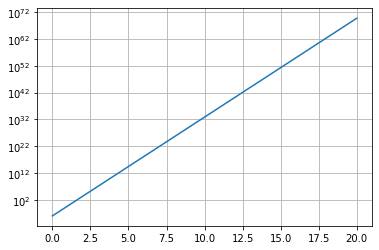

Text(0, 0.5, 'Rain fall rate ($s^{-2}$)')

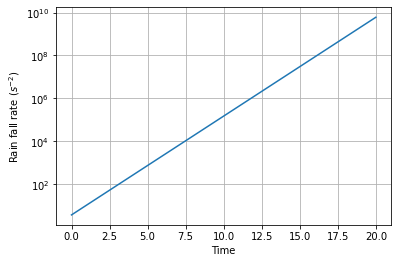

In [ ]:
# rain production
vap = vap_P(T, 2.5e6)
rho = air_density(T, P, vap)
print(rho)

def RK4(qr, qc, start, end, N):
    time = np.linspace(start,end,N)
    h = (end-start)/N
    rain = []
    fall = []
    for t in time:
        if t==0:
            qr=qr
        else:
            k1 = h*make_rain(qr, qc, t)
            k2 = h*make_rain(qr+k1/2, qc, t+h/2)
            k3 = h*make_rain(qr+k2/2, qc, t+h/2)
            k4 = h*make_rain(qr+k3, qc, t+h)
            qr += (k1+2*k2+2*k3+k4)/6
          
        rain.append(qr)
        fall_vel = FV(qr, rho)
        fall.append(fall_vel)
    rain = np.array(rain)
    time = np.array(time)
    fall = np.array(fall)
    return time, rain, fall

rate = RK4(0.0001, 0.5, 0, 20, 1000)

plt.plot(rate[0], rate[1])
plt.yscale("log")
plt.grid()
plt.show()
plt.plot(rate[0], rate[2])
plt.yscale("log")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Rain fall rate ($s^{-2}$)")